In this notebook the EfficientNetB0 is used as a pretrained model.

To use a pretrained model, only the convolutational layers of the model are imported and frozen (e.g. they will not be retrained). The top layers of the model are added according to the needs.


__Import and installations__

In [8]:

import cv2
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.applications import EfficientNetB0


The data set is split into training and test.

In [9]:
# Directories
src_dir = "/Users/linn/Desktop/original_dataset/train_data"
dst_dir = "/Users/linn/Desktop/original_dataset/test_data"

# Make sure destination directory exists
os.makedirs(dst_dir, exist_ok=True)

# Proportion of images to use for testing
test_ratio = 0.2

# Seed for reproducibility
np.random.seed(42)

# Counter for tracking moved images
total_moved_images = 0

# For each class directory in the source directory
for class_dir in os.listdir(src_dir):
    if os.path.isdir(os.path.join(src_dir, class_dir)):
        # List all image files in this class directory
        images = os.listdir(os.path.join(src_dir, class_dir))
        
        # Determine the number of images to move
        n_test_images = int(len(images) * test_ratio)
        
        # Select the first n_test_images from each class
        test_images = images[:n_test_images]
        
        # Create a new directory for this class in the destination directory
        os.makedirs(os.path.join(dst_dir, class_dir), exist_ok=True)
        
        # Move the test images to the destination directory if the destination directory is empty
        if len(os.listdir(os.path.join(dst_dir, class_dir))) == 0:
            for image in test_images:
                shutil.move(os.path.join(src_dir, class_dir, image), os.path.join(dst_dir, class_dir, image))
                total_moved_images += 1

# Print the number of images moved
if total_moved_images > 0:
    print(f"Moved {total_moved_images} images from {src_dir} to {dst_dir}.")
else:
    print("No images were moved because the destination directory is not empty.")


No images were moved because the destination directory is not empty.


The reamaing train data is further split into train and validation. For this the ImageDataGenerator is used. it also augments and rescales the images.
The batch size and the image size can be chosen. 
For EfficientNetB0 an image size of 224 is needed.

In [10]:
batch_size= 32
image_size = (224, 224)

input_dir = "/Users/linn/Desktop/original_dataset/train_data"

train_datagen= ImageDataGenerator(
    rotation_range=135,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #shear_range = 0.05,
    #zoom_range = 0.5,
    rescale= 1./255,
    # brightness_range =  (0.0,1),
    fill_mode="constant", # cval is the value used for points outside the boundaries when fill_mode is "constant"
                        # besides "constant" there are "nearest", "reflect" and "wrap". the fill_mode is used when the image is augmented and the size of the image changes
    validation_split = 0.2
    )

val_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(directory=input_dir, batch_size=batch_size, target_size=image_size, color_mode="rgb", class_mode = 'sparse', subset="training")
val_generator = val_datagen.flow_from_directory(directory= input_dir, batch_size=batch_size, target_size=image_size, color_mode="rgb", class_mode = 'sparse', subset="validation")

Found 183 images belonging to 4 classes.
Found 43 images belonging to 4 classes.


The model is created from the pretrained and the additional layers.

In [11]:
#define image size and image shape
image_size = (224, 224)
IMG_shape = image_size + (3,)

#create the convolutional base from pretrained model
conv_base = EfficientNetB0(include_top=False, weights="imagenet", input_shape = IMG_shape)

#create a model and add the pretrained model and other layers to it.

model = models.Sequential()
model.add(conv_base)

#freeze the convolutation base of the pretrained model. The top layers (e.g. bottom layers with classification) can still be changed now.
conv_base.trainable = False

#add more layers to the convolutional base (additional possible layers are outcommented)

#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten(name="flatten"))
#model.add(layers.Dropout(0.2, name="dropout_out"))
#model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation="softmax", name="fc_out"))

#show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 fc_out (Dense)              (None, 4)                 516       
                                                                 
Total params: 12078375 (46.08 MB)
Trainable params: 8028804 (30.63 MB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [12]:
# Compile the model
model.compile(optimizer='Adam',
              # loss='sparse_categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


Finally the model is fitted.
Here the number of epochs and the steps per epoch could be changed.

In [13]:
#define the settings
steps_per_epoch = train_generator.n // batch_size
num_epochs = 30
validation_steps = len(val_generator)

# Train the model, store into history for later plotting   
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs,
    validation_data=val_generator, 
    validation_steps=validation_steps
)


Epoch 1/30
3/5 [=================>............] - ETA: 3s - loss: 22.7181 - accuracy: 0.3021

KeyboardInterrupt: 

The train and validation accuracy and loss during the epochs can be plotted.
If given a meaningful title, results can be compared later.

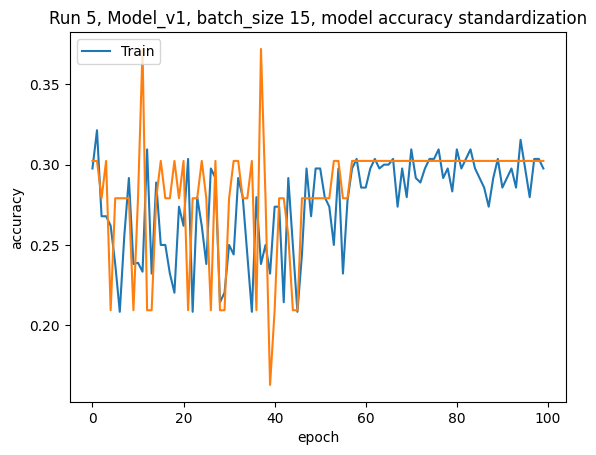

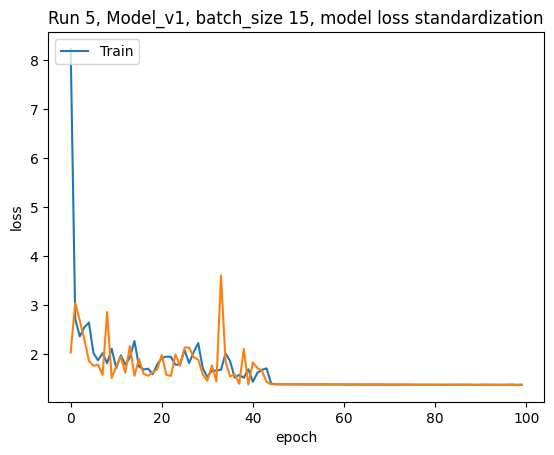

In [ ]:
# plotting the loss and accuracy
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Run 5, Model_v1, batch_size 15, model accuracy standardization')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Run 5, Model_v1, batch_size 15, model loss standardization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

#with adam, batch_size 15,

#SGD was not better!